# tSNE to visualize digits

todos

* VAE

reference

1. https://scipy-lectures.org/packages/scikit-learn/auto_examples/plot_tsne.html

In [1]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from sklearn.utils import shuffle

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline

## PCA

In [2]:
dataset = MNIST('~/.torch/data', train=True, transform=lambda x: np.array(x))
dataloader = DataLoader(dataset, shuffle=True, batch_size=500)

In [3]:
images, labels = next(iter(dataloader))
images = images.numpy().reshape((500, -1))
labels = labels.numpy()

In [4]:
from sklearn.decomposition import PCA

pca_components = 30
pca = PCA(n_components=pca_components)
X = pca.fit_transform(images)

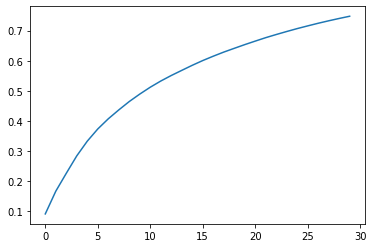

In [5]:
from itertools import accumulate

cumsum = [x for x in accumulate(pca.explained_variance_ratio_)]

plt.plot(list(range(pca_components)), cumsum)

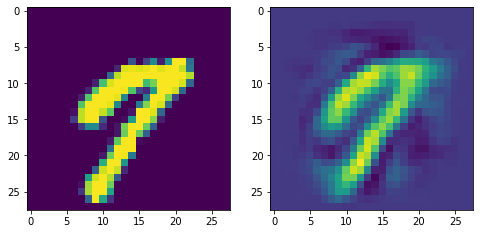

In [6]:
images_recovered = pca.inverse_transform(X)

index = 75

fig, axs = plt.subplots(1, 2, figsize=(8, 5))
axs[0].imshow(images[index].reshape((28, 28)))
axs[1].imshow(images_recovered[index].reshape((28, 28)))

### tSNE

In [7]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30)  # perplexity=30 default
X_2d = tsne.fit_transform(X)

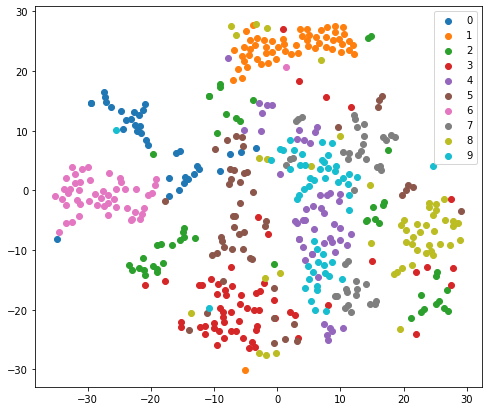

In [8]:
plt.figure(figsize=(8, 7))

cmap = plt.cm.get_cmap('hsv', 10)
for i in range(10):
    plt.scatter(X_2d[labels == i, 0], X_2d[labels == i, 1], cmap=cmap(i), label=str(i))
    
plt.legend()

## Autoencoder

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [10]:
# https://github.com/L1aoXingyu/pytorch-beginner/blob/master/08-AutoEncoder/conv_autoencoder.py

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # 16 x 10 x 10
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # 16 x 5 x 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # 8 x 3 x 3
            nn.ReLU(),
            nn.MaxPool2d(2, stride=1),  # 8 x 2 x 2
            nn.Sigmoid(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # 16 x 5 x 5
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # 8 x 15 x 15
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # 1 x 28 x 28
            nn.Tanh()
        )
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def features(self, x):
        if not self.training:
            x = self.encoder(x)
        else:
            raise RuntimeError
        return self.flatten(x).detach().numpy()

### data loader

In [11]:
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

batch_size = 128


class MnistX2Dataset(Dataset):
    def __init__(self):
        self.data = MNIST('~/.torch/data', train=True, transform=transforms.Compose([
            transforms.ToTensor(),
        ]))
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item, target = self.data[index]
        return item, item


dataset = MnistX2Dataset()
train_size = 0.8
train_size = train_size * len(dataset)
train_size = int(train_size)
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])
data_loader = {
    'train': DataLoader(train_set, shuffle=True, batch_size=batch_size),
    'val': DataLoader(val_set, shuffle=False, batch_size=batch_size),
}

In [12]:
images0, images1 = next(iter(data_loader['train']))

In [13]:
images1.shape

torch.Size([128, 1, 28, 28])

### model training

In [14]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss

In [16]:
device = torch.device('cuda')

learning_rate = 3e-3

model = Autoencoder().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
evaluator = create_supervised_evaluator(model, metrics={'loss': Loss(criterion)}, device=device)

In [17]:
num_epochs = 100

@trainer.on(Events.EPOCH_COMPLETED(every=5))
def log_loss(trainer):
    print(f'\nEpoch: {trainer.state.epoch} -', end=' ')
    for ds in ['train', 'val']:
        evaluator.run(data_loader[ds])
        metrics = evaluator.state.metrics
        print(f'{ds} loss: {metrics["loss"]:.4f}', end=' ')
        
        
trainer.run(data_loader['train'], max_epochs=num_epochs)


Epoch: 5 - train loss: 0.0348 val loss: 0.0349 
Epoch: 10 - train loss: 0.0310 val loss: 0.0311 
Epoch: 15 - train loss: 0.0294 val loss: 0.0294 
Epoch: 20 - train loss: 0.0288 val loss: 0.0288 
Epoch: 25 - train loss: 0.0285 val loss: 0.0285 
Epoch: 30 - train loss: 0.0280 val loss: 0.0281 
Epoch: 35 - train loss: 0.0278 val loss: 0.0279 
Epoch: 40 - train loss: 0.0273 val loss: 0.0274 
Epoch: 45 - train loss: 0.0276 val loss: 0.0277 
Epoch: 50 - train loss: 0.0272 val loss: 0.0273 
Epoch: 55 - train loss: 0.0274 val loss: 0.0274 
Epoch: 60 - train loss: 0.0271 val loss: 0.0271 
Epoch: 65 - train loss: 0.0270 val loss: 0.0270 
Epoch: 70 - train loss: 0.0273 val loss: 0.0274 
Epoch: 75 - train loss: 0.0268 val loss: 0.0269 
Epoch: 80 - train loss: 0.0270 val loss: 0.0271 
Epoch: 85 - train loss: 0.0269 val loss: 0.0270 
Epoch: 90 - train loss: 0.0267 val loss: 0.0267 
Epoch: 95 - train loss: 0.0266 val loss: 0.0267 
Epoch: 100 - train loss: 0.0265 val loss: 0.0266 

State:
	iteration: 37500
	epoch: 100
	epoch_length: 375
	max_epochs: 100
	output: 0.027179991826415062
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [18]:
torch.save(model.state_dict(), 'data/models/mnist-checkpoint-1.pth')

In [19]:
model = Autoencoder()
checkpoint = torch.load('data/models/mnist-checkpoint-1.pth')
model.load_state_dict(checkpoint)
model.eval();

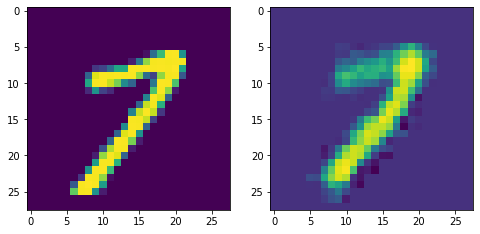

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

images0, images1 = next(iter(data_loader['train']))
images2 = model(images0)

index = 80

fig, axs = plt.subplots(1, 2, figsize=(8, 5))

axs[0].imshow(images0[index].view(28, 28))
axs[1].imshow(images2[index].detach().numpy().reshape((28, 28)))

## tSNE

In [21]:
dataset = MNIST('~/.torch/data', train=True, transform=transforms.ToTensor())
train_loader = DataLoader(dataset, shuffle=True, batch_size=500)

images, labels = next(iter(train_loader))
features = model.features(images)

In [22]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30)  # perplexity=30 default
X_2d = tsne.fit_transform(features)

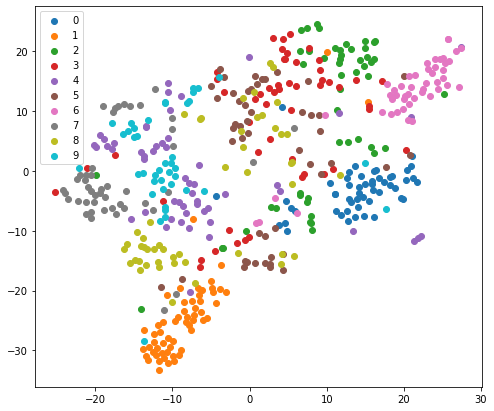

In [23]:
plt.figure(figsize=(8, 7))

cmap = plt.cm.get_cmap('hsv', 10)
for i in range(10):
    plt.scatter(X_2d[labels == i, 0], X_2d[labels == i, 1], cmap=cmap(i), label=str(i))
    
plt.legend()